### In NLU, we simply get the logits or probabilities and use them. Unlike NLU, in NLG we need a decoder to generate data from logits or probabilities.


### In NLG, we have auto regressive approach. In pre training, we have single direction attention, unlike MLM which is bidirectional

In [1]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()
     

Cloning into 'notebooks'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 515 (delta 139), reused 127 (delta 123), pack-reused 353
Receiving objects: 100% (515/515), 28.61 MiB | 11.85 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


# Greedy Search Decoding

#### Greedily Search the next token, like we have in greedy approach 

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model_name = "gpt2-large"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [7]:
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/3.02G [00:00<?, ?B/s]

In [8]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [9]:
import pandas as pd

In [10]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (11.78%),best (6.66%),only (5.62%),first (2.91%),ultimate (2.23%)
1,Transformers are the most,popular (22.63%),successful (5.55%),famous (3.38%),powerful (3.14%),important (2.54%)
2,Transformers are the most popular,toys (8.87%),toy (7.88%),of (5.03%),Transformers (4.69%),franchise (3.88%)
3,Transformers are the most popular toys,of (31.69%),in (23.73%),ever (4.85%),", (4.50%)",for (3.58%)
4,Transformers are the most popular toys of,all (57.47%),the (21.30%),2015 (2.34%),their (1.66%),2014 (1.54%)
5,Transformers are the most popular toys of all,time (94.71%),- (1.86%),. (0.66%),", (0.56%)",times (0.52%)
6,Transformers are the most popular toys of all ...,. (34.98%),", (33.86%)",and (7.03%),! (2.16%),in (1.73%)
7,Transformers are the most popular toys of all ...,They (10.93%),\n (9.23%),The (6.63%),In (2.91%),And (2.68%)


##### Generate Method

In [11]:
input_ids = tokenizer(input_txt, return_tensors = "pt")["input_ids"].to(device)

In [12]:
model.generate(input_ids, max_new_tokens=n_steps, do_sample = False)

tensor([[41762,   364,   389,   262,   749,  2968, 14958,   286,   477,   640,
            13,  1119]], device='cuda:0')

In [13]:
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample = False)

In [14]:
tokenizer.decode(output[0])

'Transformers are the most popular toys of all time. They'

In [15]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors = "pt")["input_ids"].to(device)

In [16]:
input_ids

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198]], device='cuda:0')

In [17]:
output_greedy = model.generate(input_ids, max_length = max_length, do_sample = False)

In [18]:
output_greedy

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198,   464,  4837,    11,
          2957,   416,  1583,    13,  3271,   371,    13,  6484,   286,   262,
          2059,   286,  3442,    11,  8909,  8742,    11,  5071,   262, 28000,
         19942,   287,   262,   843,   274, 21124,   286, 25768,    13,   383,
          1989,   318,  1900,   329,   663,  3748,  4903,  1435,   290,   318,
          1363,   284,   257,  1271,   286,  4071,  4693,   286,  4695,    13,
           628,   198,   464,  4837,  1043,   262, 28000, 19942,   287,   262,
           843,   274, 21124,   286, 25768,    13,   383,  1989,   318,  1900,
           329,   663,  3748,  4903,  1435,   290,  

In [19]:
tokenizer.decode(output_greedy[0])

'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\n\nThe researchers, led by Dr. David R. Williams of the University of California, Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home to a number of rare species of animals.\n\n\nThe researchers found the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home'

In [20]:
#### This is producing repetitive results, greedy approach leads to this.
#### Greedy can be used where we want to produce short sequences like arithmetic where a determenistic and factually correct output 
#### is desired

# Beam Search Decoding

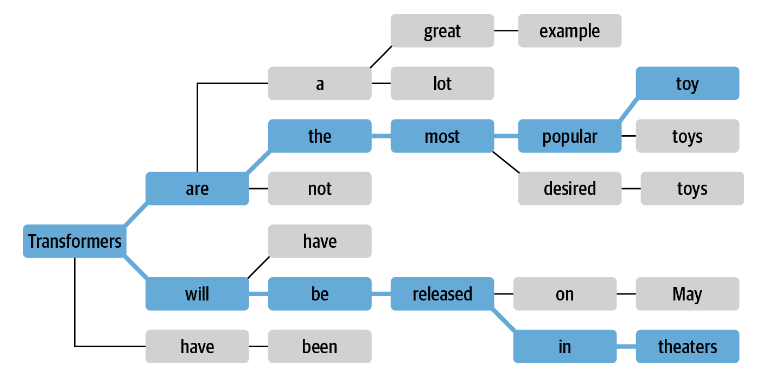

In [21]:
### We use log probabilities. Probabilities range from [0,1] . Beams can be very huge so calculating 
### conditional probabilities can lead to vert small results, so this can lead to underflow

In [22]:
0.5 ** 1024

5.562684646268003e-309

In [23]:
### Log probabilities can lead to much better results

In [24]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [25]:

def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()
     

In [26]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home

log-prob: -86.50


In [27]:
#### generating via beam search.
#### use num_beams parameter to generate these beams.
#### The more beams, the better result, but more resource hungry

In [28]:
output_beam = model.generate(input_ids, max_length = max_length, num_beams = 5, do_sample=False)

In [29]:
tokenizer.decode(output_beam[0])

'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\n\nThe discovery was made by a team of researchers from the University of California, Santa Cruz, and the University of California, Santa Cruz, and published in the Journal of Mammalogy.\n\n\nThe team, led by Dr. David Hone of the University of California, Santa Cruz, discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains.\n\n\n'

In [30]:
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))

In [31]:
print(logp)

-65.19762


In [32]:
### Countering repetitive words  with n_gram penalty

output_beam = model.generate(input_ids, max_length = max_length, num_beams = 5, do_sample = False, no_repeat_ngram_size=2)

In [33]:
print(tokenizer.decode(output_beam[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the National Geographic Society. The team was led by
Dr. Richard Wrangham, a professor of ecology and evolutionary biology at UCSC.

"We've known for a long time that there are animals that live in remote areas of
the world, but this is the first time we've been able


In [34]:
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))

In [35]:
logp

array(-79.01732, dtype=float32)


# Sampling Methods

### 1. Via Temprature

In [36]:
### Temprature:
#### When T>1, more focus on rare/giberish tokens.
##### When T<1, more coherence but less diversity

In [39]:
torch.manual_seed(42);

In [42]:
## High Temp
output_temp = model.generate(input_ids, max_length = max_length, do_sample=True, temperature=2.0, top_k = 0)

In [43]:
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Leé kilograms wolfside right flank mourning sw done because Dillon territ
-chenokmininthDirector Lav Awakensli Bald opted sealing electrons glasses
306157262 Qomo Trouble catalogue related disorder b Skywolf spite SabbnessCtrie
illustCHDBfully fluids 2008 anautsche own representation DA Rhino castle
colourful Zeus sprung CH beating Column HA woes compliance vet B relay antenna
pictures phones Filipino East territory Sick Sho Prototype BASstrength cardboard


In [44]:
## Low Temp
torch.manual_seed(42);
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists, who have been studying the animals for the past 20 years, have
named the unicorns "Unicorn Valley" after the valley in which they live.

"We had never heard of this valley before and it's a bit of a surprise," said
Dr. Jens-Christian Ström, a researcher at the University of Bern in Switzerland,
who led the study. "


### 2. Top k and top p (Nuclues) sampling

In [45]:
### Idea: Restrict the number of possible values from which we can sample

In [46]:
torch.manual_seed(42)

In [47]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [48]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

In [49]:
probs

array([[9.6631875e-06, 9.5639892e-02, 1.6432008e-04, ..., 1.8450563e-09,
        1.1102776e-08, 1.3767105e-06]], dtype=float32)

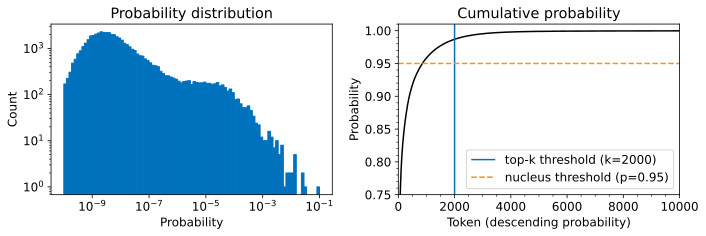

In [50]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()
     

In [51]:
### Top K


output_topk = model.generate(input_ids, max_length = max_length, do_sample = True, top_k = 50)

In [53]:
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam in the low mountains of the Andes, making it hard for
human beings to find them. (Photo by H.K. Kim/AP Images)

An analysis of the findings from the Himalayan Project's expedition into the
Valley of the Unicorn concluded that the unicorns are actually descendants of
wild horses killed by the Indians before their migration to the Americas. The
horses weren


In [54]:
#### How to choose K??

#### Use different metrics that we will discuss in next chapter

In [55]:
#### Top p :  Dynamic cutoff. Can set p = 0.90, we will take all the tokens that come under 90 %


In [56]:

output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))
     

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Scientists from the Universidad de Concepcion (UCD) and the Universidad de Nueva
Esparta (UNE) in Santiago, Chile, have made headlines around the world with the
discovery that a herd of unicorns living in a remote, previously unexplored
valley, in the Andes Mountains, has been revealed.


"It is not uncommon to see birds like albatrosses


In [57]:
#### combining top_p and top_k:
### If top_k = 50, top_p = 0.90  ;  take 90 % probability from top k tokens